In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
import helpfunction as helper

In [3]:
%autoreload

In [4]:
outdir= './output/FlashHypo/'
inputdir = './input/ACPTMay/run1_v13/'  
slice_id_name = "pandoraSliceId"

nrPMT = 32
rangePMT = range(nrPMT)

sample_names = ['nue','nu','on','off']
file_names = [next((s for s in os.listdir(inputdir) if "NuCC_"+sample+'_' in s), None) for sample in sample_names]
print(file_names)
sample_names_title = dict(zip(sample_names, [r"Intrinsic $\nu_e$", r"BNB $\nu$", r"BNB on (4.4e19)", r"BNB off (data)"]))

['NuCC_nue_overlay.root', 'NuCC_nu_overlay.root', 'NuCC_on_data.root', 'NuCC_off_data.root']


In [5]:
def search_unsorted(index_large, values_large, index_subset):
    if (len(index_large)!=len(values_large)):
        return -1
    sorter = np.argsort(index_large)
    return values_large[sorter][np.searchsorted(index_large[sorter], index_subset)]

In [6]:
file_flashes = {}
file_slices = {}
file_events = {}
for i, (idx, fn) in enumerate(zip(sample_names, file_names)):
    print(fn)
    file_flashes[idx] = uproot.open(inputdir+fn)[slice_id_name+'/flashes']
    file_slices[idx] = uproot.open(inputdir+fn)[slice_id_name+'/slices']
    file_events[idx] = uproot.open(inputdir+fn)[slice_id_name+'/events']
    print(file_events[idx].numentries)

NuCC_nue_overlay.root
65732
NuCC_nu_overlay.root
172921
NuCC_on_data.root
148128
NuCC_off_data.root
453903


In [7]:
file_events['nue'].keys()

[b'run',
 b'subRun',
 b'event',
 b'evt_time_sec',
 b'evt_time_nsec',
 b'nFlashes',
 b'nFlashesInBeamWindow',
 b'hasBeamFlash',
 b'nSlices',
 b'nSlicesAfterPrecuts',
 b'foundATargetSlice',
 b'targetSliceMethod',
 b'bestCosmicMatch',
 b'cosmicMatchHypothesis',
 b'nuInteractionType',
 b'nuCCNC',
 b'nuEnergy',
 b'leptonEnergy',
 b'nuInteractionTime',
 b'nuPdgCode',
 b'nuVertexX',
 b'nuVertexY',
 b'nuVertexZ']

In [8]:
# Flash plots
file_flashes['nu'].keys()

[b'run',
 b'subRun',
 b'event',
 b'evt_time_sec',
 b'evt_time_nsec',
 b'time',
 b'centerY',
 b'centerZ',
 b'widthY',
 b'widthZ',
 b'totalPE',
 b'peSpectrum',
 b'inBeamWindow',
 b'isBrightestInWindow',
 b'isBeamFlash']

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


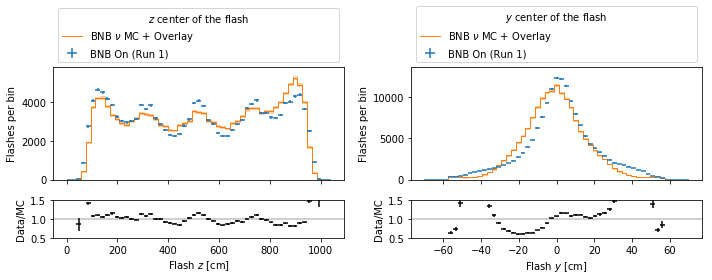

In [9]:
fig, axes = plt.subplots(nrows = 2, ncols=2, sharex='col', figsize=(10,4), gridspec_kw = {'height_ratios':[3, 1]})
axes = [[axes[0][0], axes[1][0]], [axes[0][1], axes[1][1]] ]
fields = ['centerZ', 'centerY']
lab = [r'$z$', r'$y$']
x_min = [0, -70]
x_max = [1040, 70]
N=55

mc_scale = file_flashes['nu'].numentries / file_flashes['on'].numentries
mc_lab = r'BNB $\nu$ MC + Overlay'
data_lab = 'BNB On (Run 1)'


for ax, field, l, xmin, xmax in zip(axes, fields, lab, x_min, x_max):
    masks = [file_flashes['nu'].array('totalPE')>200, file_flashes['on'].array('totalPE')>200]
    data = [file_flashes['nu'].array(field), file_flashes['on'].array(field)]
    edges, edges_mid, bins, err, max_y = helper.histHelper(N, xmin, xmax, data, weights=[1/mc_scale,1])
    ax[0].step(edges_mid, bins[0], lw=1, label=mc_lab, where='mid', color='C1')
    ax[0].fill_between(edges_mid, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='mid', color='C1')
    ax[0].errorbar(edges_mid, bins[1], yerr=err[1], xerr=edges[:-1]-edges_mid, fmt='none', c='C0', 
                   zorder=3, label=data_lab)
    ax[0].set_ylabel("Flashes per bin")
    ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=l+' center of the flash', loc='lower center', mode='expand')
    ax[0].set_ylim(0, max(max_y)*1.1)

    ratio = bins[1]/(bins[0])
    ratio_err = np.sqrt(1/bins[1]+1/ (bins[0]/mc_scale))*ratio
    ax[1].errorbar(edges_mid, ratio, xerr= edges[1:]-edges_mid, yerr=ratio_err, fmt='none', color='k')

    ax[1].axhline(y=1,color="k",alpha=0.25)
    ax[1].set_xlabel('Flash '+l+' [cm]')
    ax[1].set_ylabel("Data/MC")
    ax[1].set_ylim(0.5,1.5)
    
fig.tight_layout()    
fig.savefig(outdir+"flashxz.pdf")

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


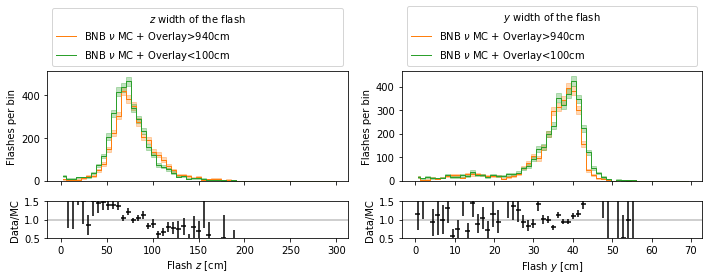

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols=2, sharex='col', figsize=(10,4), gridspec_kw = {'height_ratios':[3, 1]})
axes = [[axes[0][0], axes[1][0]], [axes[0][1], axes[1][1]] ]
fields = ['widthZ', 'widthY']
lab = [r'$z$', r'$y$']
x_min = [0, 0]
x_max = [300, 70]
N=55

mc_scale = file_flashes['nu'].numentries / file_flashes['on'].numentries
mc_lab = r'BNB $\nu$ MC + Overlay'
data_lab = 'BNB On (Run 1)'


for ax, field, l, xmin, xmax in zip(axes, fields, lab, x_min, x_max):
    masks = [file_flashes['nu'].array('centerZ')>940, file_flashes['nu'].array('centerZ')<100]
    data = [file_flashes['nu'].array(field)[masks[0]], file_flashes['nu'].array(field)[masks[1]]]
    edges, edges_mid, bins, err, max_y = helper.histHelper(N, xmin, xmax, data, weights=[1,1])
    ax[0].step(edges_mid, bins[0], lw=1, label=mc_lab+">940cm", where='mid', color='C1')
    ax[0].fill_between(edges_mid, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='mid', color='C1')
    ax[0].step(edges_mid, bins[1], lw=1, label=mc_lab+"<100cm", where='mid', color='C2')
    ax[0].fill_between(edges_mid, bins[1] - err[1], bins[1] + err[1], alpha=0.3, step='mid', color='C2')
    
    ax[0].set_ylabel("Flashes per bin")
    ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=l+' width of the flash', loc='lower center', mode='expand')
    ax[0].set_ylim(0, max(max_y)*1.1)

    ratio = bins[1]/(bins[0])
    ratio_err = np.sqrt(1/bins[1]+1/ (bins[0]/mc_scale))*ratio
    ax[1].errorbar(edges_mid, ratio, xerr= edges[1:]-edges_mid, yerr=ratio_err, fmt='none', color='k')

    ax[1].axhline(y=1,color="k",alpha=0.25)
    ax[1].set_xlabel('Flash '+l+' [cm]')
    ax[1].set_ylabel("Data/MC")
    ax[1].set_ylim(0.5,1.5)
    
fig.tight_layout()    
fig.savefig(outdir+"flashyz.pdf")

### 2(H-O)/(H+O)-plot

In [11]:
def fillratio(sample, data=True):
    f_flashes = file_flashes[sample]
    f_slices = file_slices[sample]

    flash_ids = f_flashes.array("evt_time_nsec")
    flash_pes = f_flashes.array("peSpectrum")
    
    slice_hypos = f_slices.array("peHypothesisSpectrum")
    slice_flashmatched = (slice_hypos.counts==32) & (slice_hypos.sum()>0.0)
    
    if data:
        slice_selected = f_slices.array("isTaggedAsTarget")
        slice_mask =  slice_flashmatched & slice_selected
    else:
        slice_purity = f_slices.array("purity")>0.8
        slice_completeness = f_slices.array("completeness")>0.8
        slice_mask = slice_purity & slice_completeness & slice_flashmatched
    
    slice_ids = f_slices.array("evt_time_nsec")[slice_mask]
    slice_hypos = np.array(slice_hypos[slice_mask])
    slice_pe = np.array(search_unsorted(flash_ids, flash_pes, slice_ids))

    #pe mask:
    pe_mask = np.sum(slice_pe, axis=1)>200
    slice_hypos=slice_hypos[pe_mask]
    slice_pe=slice_pe[pe_mask]
    
    # 2(H-O)/(H+O)
    a = 2*(slice_hypos-slice_pe)
    b = (slice_hypos+slice_pe)
    y_vals = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    mask = (slice_hypos<1) & (slice_pe<1)
    y_vals[mask]=-3
    
    y = np.nan_to_num(y_vals).T.flatten()
    x = np.repeat(range(32),len(y_vals))
    return x,y

nue
52653.0
nu
71918.0
on
34357.0
off
70522.0


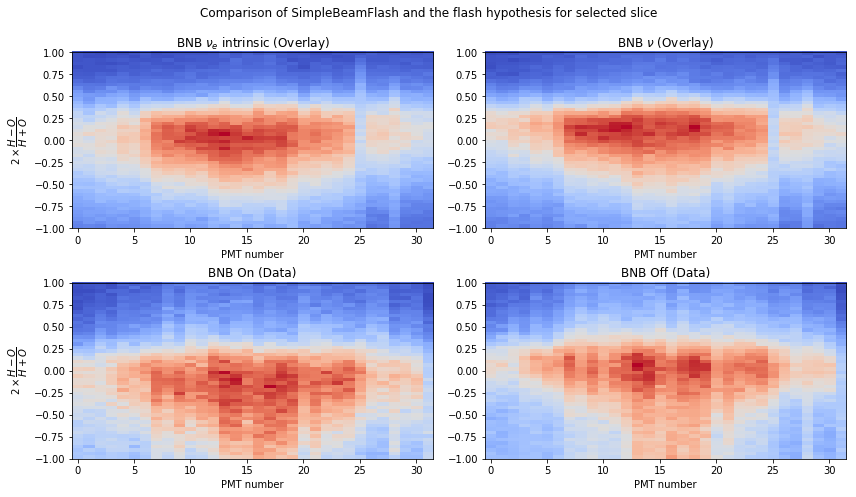

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12,7))
ax=axes.flatten()
sample_titles = [r"BNB $\nu_e$ intrinsic (Overlay)", r"BNB $\nu$ (Overlay)", "BNB On (Data)", "BNB Off (Data)"]

for i,(s,t) in enumerate(zip(sample_names, sample_titles)):
    print(s)
    x,y = fillratio(s)
    print(len(x)/32)
    ax[i].hist2d(x,y, range=((-0.5,31.5),(-1,1)), bins=(32,50), cmap="coolwarm")
    ax[i].set_xlabel(r"PMT number")
    ax[i].set_title(t)
    
ax[0].set_ylabel(r"$2 \times \dfrac{H-O}{H+O}$")
ax[2].set_ylabel(r"$2 \times \dfrac{H-O}{H+O}$")

fig.tight_layout()
fig.suptitle("Comparison of SimpleBeamFlash and the flash hypothesis for selected slice")
fig.subplots_adjust(top=0.89)
fig.savefig(outdir+"hypo_spec.pdf", bbox_inches='tight')

In [13]:
#pmt15 = list(np.nan_to_num(y_vals).T[15])
#plt.hist(pmt15, range=(-4,2))
file_events['nue'].keys()

[b'run',
 b'subRun',
 b'event',
 b'evt_time_sec',
 b'evt_time_nsec',
 b'nFlashes',
 b'nFlashesInBeamWindow',
 b'hasBeamFlash',
 b'nSlices',
 b'nSlicesAfterPrecuts',
 b'foundATargetSlice',
 b'targetSliceMethod',
 b'bestCosmicMatch',
 b'cosmicMatchHypothesis',
 b'nuInteractionType',
 b'nuCCNC',
 b'nuEnergy',
 b'leptonEnergy',
 b'nuInteractionTime',
 b'nuPdgCode',
 b'nuVertexX',
 b'nuVertexY',
 b'nuVertexZ']

### Single flash event viewer

In [14]:
df = file_events['nu'].pandas.df(flatten=False)

In [15]:
cols = ['run', 'subRun', 'event', 'nuEnergy']
df_view = df.query("targetSliceMethod==2 & nSlices==4")[cols]
run_arr = df_view['run']
subRun_arr = df_view['subRun']
event_arr = df_view['event']

In [18]:
fn = 'input/flashID_tree.root'
file_flashes['test'] = uproot.open(fn)[slice_id_name+'/flashes']
file_slices['test'] = uproot.open(fn)[slice_id_name+'/slices']
file_events['test'] = uproot.open(fn)[slice_id_name+'/events']

In [22]:
file_events['test'].array('run')

array([7008], dtype=int32)

Run 7008 , Subrun 1317 , Event 65854  found! 
 ------------------------------

--- EVENT INFO ---
nFlashes :	 2
hasBeamFlash :	 True
nSlices :	 4
nSlicesAfterPrecuts :	 1
foundATargetSlice :	 True
nuCCNC :	 0
nuEnergy :	 1.6330262
leptonEnergy :	 1.032563
nuInteractionTime :	 4495.4116
nuPdgCode :	 12
nuVertexX :	 51.529762
nuVertexY :	 -60.063267
nuVertexZ :	 775.19183

--- FLASH INFO ---
time :	 [ 4.96625 13.00625]
centerY :	 [-13.28242 -49.30499]
centerZ :	 [718.5781 737.2523]
widthY :	 [41.601425 17.80866 ]
widthZ :	 [174.08687 197.1121 ]
totalPE :	 [6428.946   538.3031]
inBeamWindow :	 [ True False]
isBeamFlash :	 [ True False]

--- SLICE INFO ---
hasDeposition :	 [ True  True  True  True]
totalCharge :	 [151220.8    39543.78   53932.137   9369.687]
centerX :	 [171.5835   48.83766  63.23367 107.46119]
centerY :	 [-54.709476 -46.298237 -91.86293  -42.196503]
centerZ :	 [489.5638 482.3237 810.9449  28.4175]
nHits :	 [3534  995 1370  307]
deltaY :	 [-41.427055 -33.015816 -78.58051  -

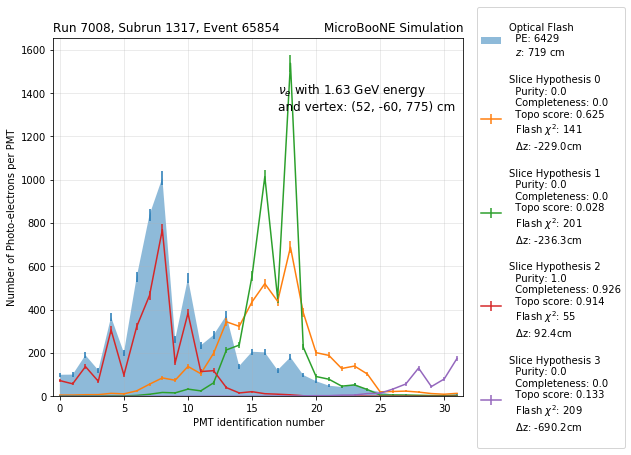

In [23]:
sample = "test"
run = 7008
subrun = 1317
event = 65854

sample_dict = {'events': file_events[sample],
               'flashes': file_flashes[sample],
               'slices': file_slices[sample]
              }

helper.SingleEventViewer(run,subrun,event, sample_dict, save_plot=True)

### Plots about the PE per PMT

In [17]:
# Save the PE values of beam flashes in a seperate numpy array:
# For the rolling sample, We only want to compare the PE rates with the run3/4 part
# https://microboone-exp.fnal.gov/at_work/AnalysisTools/data/ub_datasets_optfilter.html

#sample_names = ['nue','nu','on','off']
#file_flashes

#scales = [scale_nue, scale_nu, scale_on, scale_off]
scales = [0.0010569228435649161, 0.45681583509311513, 1, 0.2849382369772876]

df_pe = []
for f,s,w in zip(file_flashes, sample_names,scales):
    mask = file_flashes[s].array("totalPE")>200
    pes = np.array(file_flashes[s].array("peSpectrum")[mask])
    pes = pes.astype(float)
    print(len(pes))
    df = pd.DataFrame(pes)
    df['weight'] = w
    df['sample'] = s
    df_pe.append(df)
df_pe = pd.concat(df_pe)

10855
8387
29813
55301


In [18]:
cols = ["PMT"+str(i) for i in rangePMT]
cols.extend(df_pe.columns[-2:])
df_pe.columns = cols
df_pe.head()

,PMT0,PMT1,PMT2,PMT3,PMT4,PMT5,PMT6,PMT7,PMT8,PMT9,...,PMT24,PMT25,PMT26,PMT27,PMT28,PMT29,PMT30,PMT31,weight,sample
0,0.000000,0.429764,0.000000,0.000000,0.000000,0.000000,0.716975,1.479750,2.676526,7.477969,...,142.441910,55.082512,92.396591,121.665749,137.439041,74.687378,60.417450,120.651848,0.001057,nue
1,0.000000,0.000000,0.533602,0.315870,6.357217,2.461547,9.033563,14.145624,16.931545,21.582726,...,413.850128,85.512459,224.251053,199.732315,167.564392,118.651978,112.500031,159.460617,0.001057,nue
2,40.532505,31.378685,45.943615,26.275742,46.656151,28.941477,44.328609,33.838913,20.148411,16.119347,...,0.000000,0.000000,0.000000,0.000000,2.603557,0.000000,0.000000,0.000000,0.001057,nue
3,6.704206,2.617096,2.796740,9.421261,9.531974,15.299553,14.602509,68.935150,108.039070,109.138481,...,175.480713,21.970263,22.424629,20.589430,19.772240,12.584557,9.518528,3.427132,0.001057,nue
4,0.260426,0.000000,0.234751,0.000000,0.118182,0.965570,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.073168,0.000000,0.000000,0.000000,0.001057,nue


In [19]:
means = df_pe.groupby(['sample']).mean()
print(means)

             PMT0       PMT1       PMT2       PMT3       PMT4       PMT5  \
sample                                                                     
nu      38.287660  60.574658  53.835762  47.147915  42.528383  44.764880   
nue     47.379421  88.740034  80.875289  58.901286  54.337723  56.970938   
off     55.307275  55.422532  45.955505  62.925579  70.316995  64.862903   
on      56.124536  56.758052  44.645101  60.149410  68.482927  63.263030   

             PMT6       PMT7        PMT8        PMT9    ...         PMT23  \
sample                                                  ...                 
nu      51.195910  59.007208   70.384092   69.187927    ...     43.152762   
nue     65.145653  72.123402  109.781495  107.808717    ...     63.020882   
off     66.441256  79.204732   58.854909   90.636485    ...     67.892398   
on      63.918650  76.310283   58.536651   86.235837    ...     69.132501   

            PMT24      PMT25      PMT26      PMT27      PMT28      PMT29  \
samp

In [20]:
df = means.transpose()
df.drop(df.tail(1).index,inplace=True)

Text(0,0.5,'Photo-electrons')

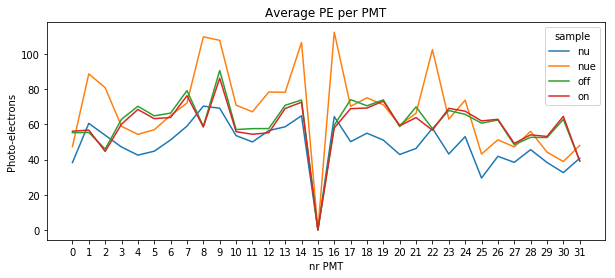

In [21]:
ax = df.plot(title='Average PE per PMT', xticks=rangePMT, figsize=(10,4))
ax.set_xticklabels(rangePMT)
ax.set_xlabel("nr PMT")
ax.set_ylabel("Photo-electrons")